In [2]:
cd Chapter06

C:\Users\revol\Chapter06


In [3]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath('__file__'))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_ont_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_ont_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_ont_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


1. 오버피팅 일어나는 것 => 300개만 가져오고 hidden layer는 7개 붙이기

In [7]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True)
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size = 784, hidden_size_list = [100, 100, 100, 100, 100, 100],
                       output_size = 10)
optimizer = SGD(lr = 0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


Text(0, 0.5, 'accuracy')

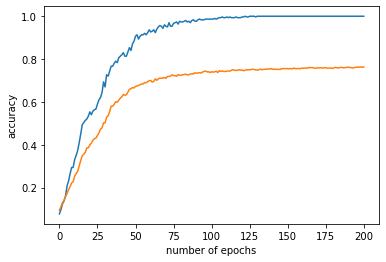

In [9]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.xlabel('number of epochs')
plt.ylabel('accuracy')

2. 가중치 감소

epoch:0, train acc:0.10333333333333333, test acc:0.1013
epoch:1, train acc:0.12, test acc:0.1236
epoch:2, train acc:0.12333333333333334, test acc:0.1476
epoch:3, train acc:0.17666666666666667, test acc:0.1663
epoch:4, train acc:0.22, test acc:0.189
epoch:5, train acc:0.26666666666666666, test acc:0.2006
epoch:6, train acc:0.29333333333333333, test acc:0.2245
epoch:7, train acc:0.32666666666666666, test acc:0.2495
epoch:8, train acc:0.3466666666666667, test acc:0.2629
epoch:9, train acc:0.37, test acc:0.2787
epoch:10, train acc:0.39, test acc:0.2942
epoch:11, train acc:0.4033333333333333, test acc:0.3022
epoch:12, train acc:0.39666666666666667, test acc:0.3062
epoch:13, train acc:0.42, test acc:0.3191
epoch:14, train acc:0.43333333333333335, test acc:0.3288
epoch:15, train acc:0.43, test acc:0.3191
epoch:16, train acc:0.43, test acc:0.3254
epoch:17, train acc:0.43333333333333335, test acc:0.3291
epoch:18, train acc:0.45666666666666667, test acc:0.3383
epoch:19, train acc:0.46, test acc:

epoch:160, train acc:0.93, test acc:0.7263
epoch:161, train acc:0.9266666666666666, test acc:0.7205
epoch:162, train acc:0.93, test acc:0.7134
epoch:163, train acc:0.9166666666666666, test acc:0.7207
epoch:164, train acc:0.92, test acc:0.7246
epoch:165, train acc:0.93, test acc:0.7277
epoch:166, train acc:0.93, test acc:0.7221
epoch:167, train acc:0.92, test acc:0.722
epoch:168, train acc:0.9266666666666666, test acc:0.7255
epoch:169, train acc:0.92, test acc:0.7232
epoch:170, train acc:0.9266666666666666, test acc:0.7198
epoch:171, train acc:0.9333333333333333, test acc:0.7255
epoch:172, train acc:0.9233333333333333, test acc:0.7197
epoch:173, train acc:0.9333333333333333, test acc:0.728
epoch:174, train acc:0.9333333333333333, test acc:0.732
epoch:175, train acc:0.9366666666666666, test acc:0.7254
epoch:176, train acc:0.9333333333333333, test acc:0.7227
epoch:177, train acc:0.9366666666666666, test acc:0.7179
epoch:178, train acc:0.93, test acc:0.7175
epoch:179, train acc:0.926666666

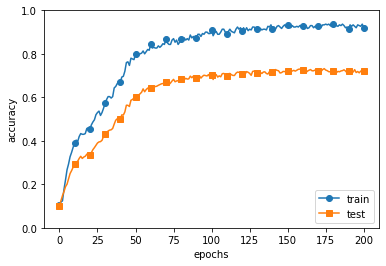

In [10]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True)

x_train = x_train[:300]
t_train = t_train[:300]

weight_decay_lambda = 0.1

network = MultiLayerNet(input_size = 784, hidden_size_list = [100, 100,100,
                                                             100, 100, 100],
                       output_size = 10, weight_decay_lambda = weight_decay_lambda)
optimizer = SGD(lr = 0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

3. 드롭아웃 => 신경망 모델이 복잡해지면 가중치 감소만으로 억제가 힘들 수 있음

In [13]:
class Dropout:#삭제할 뉴런을 mask를 이용해서 False로 표시
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

train loss:2.3145676900430145
=== epoch:1, train acc:0.12333333333333334, test acc:0.0891 ===
train loss:2.307080480063774
train loss:2.3088928689835915
train loss:2.3126405220012316
=== epoch:2, train acc:0.11666666666666667, test acc:0.0836 ===
train loss:2.304006335681961
train loss:2.311561839101963
train loss:2.3006007838715146
=== epoch:3, train acc:0.11, test acc:0.0842 ===
train loss:2.308343925965625
train loss:2.3062363149233005
train loss:2.31026432421565
=== epoch:4, train acc:0.11, test acc:0.0861 ===
train loss:2.3127646878270687
train loss:2.3076517151857563
train loss:2.2949115983516823
=== epoch:5, train acc:0.10333333333333333, test acc:0.0834 ===
train loss:2.304499393068206
train loss:2.2974030355855914
train loss:2.315928353293098
=== epoch:6, train acc:0.10333333333333333, test acc:0.0855 ===
train loss:2.2968772772224764
train loss:2.305831359320805
train loss:2.322246784842828
=== epoch:7, train acc:0.1, test acc:0.0854 ===
train loss:2.3095071069076827
train lo

train loss:2.234662513585993
train loss:2.227872073365966
train loss:2.2360937449407565
=== epoch:57, train acc:0.2, test acc:0.1775 ===
train loss:2.2449945198923693
train loss:2.24580937714584
train loss:2.2461295937698833
=== epoch:58, train acc:0.2, test acc:0.1765 ===
train loss:2.2644451710832834
train loss:2.2438242756871656
train loss:2.245736783860066
=== epoch:59, train acc:0.20333333333333334, test acc:0.1771 ===
train loss:2.2488933986591717
train loss:2.2438712722978496
train loss:2.242088218373587
=== epoch:60, train acc:0.20666666666666667, test acc:0.1791 ===
train loss:2.246844828584319
train loss:2.2397423897900213
train loss:2.256840092778897
=== epoch:61, train acc:0.20666666666666667, test acc:0.1784 ===
train loss:2.2521388959323265
train loss:2.258981735323426
train loss:2.239640217284617
=== epoch:62, train acc:0.21, test acc:0.1799 ===
train loss:2.2404146088053425
train loss:2.255312450345938
train loss:2.253513814132688
=== epoch:63, train acc:0.2133333333333

=== epoch:112, train acc:0.31, test acc:0.2432 ===
train loss:2.117044182066415
train loss:2.1245057329038572
train loss:2.1532839673732136
=== epoch:113, train acc:0.30666666666666664, test acc:0.2437 ===
train loss:2.1512752425087713
train loss:2.1872617819353564
train loss:2.151409624962319
=== epoch:114, train acc:0.31333333333333335, test acc:0.249 ===
train loss:2.160271834443613
train loss:2.135544681586045
train loss:2.152423737114974
=== epoch:115, train acc:0.31, test acc:0.2499 ===
train loss:2.1264791459036396
train loss:2.1195487092627734
train loss:2.141412092835177
=== epoch:116, train acc:0.31333333333333335, test acc:0.2488 ===
train loss:2.154440948470012
train loss:2.1303071261013393
train loss:2.131886593655763
=== epoch:117, train acc:0.31333333333333335, test acc:0.2512 ===
train loss:2.142582691920213
train loss:2.122479736735301
train loss:2.1453792353111827
=== epoch:118, train acc:0.31333333333333335, test acc:0.2503 ===
train loss:2.1039698869121635
train los

=== epoch:167, train acc:0.37, test acc:0.3011 ===
train loss:1.9637261638514678
train loss:1.8838773185851565
train loss:1.9428435814220137
=== epoch:168, train acc:0.37, test acc:0.3007 ===
train loss:1.927239667396313
train loss:1.9327489976281476
train loss:1.8921238482544063
=== epoch:169, train acc:0.37, test acc:0.3017 ===
train loss:1.8944614216905253
train loss:1.925040805107309
train loss:1.903442895890648
=== epoch:170, train acc:0.36666666666666664, test acc:0.3011 ===
train loss:1.8362122879197473
train loss:1.875465825419754
train loss:1.8286666064322716
=== epoch:171, train acc:0.36666666666666664, test acc:0.298 ===
train loss:1.9318006079598684
train loss:1.8864736419340369
train loss:1.8889541111017716
=== epoch:172, train acc:0.36666666666666664, test acc:0.2985 ===
train loss:2.000987373533265
train loss:1.9482023554978982
train loss:1.900942295990394
=== epoch:173, train acc:0.36666666666666664, test acc:0.3024 ===
train loss:1.938506682234164
train loss:1.86340681

=== epoch:222, train acc:0.44666666666666666, test acc:0.3639 ===
train loss:1.6714408220767418
train loss:1.6865936363403742
train loss:1.5539043602351084
=== epoch:223, train acc:0.44333333333333336, test acc:0.3638 ===
train loss:1.7324332628759722
train loss:1.671395199342609
train loss:1.6505641657234533
=== epoch:224, train acc:0.45, test acc:0.3629 ===
train loss:1.5776355959956678
train loss:1.6288961279187513
train loss:1.6256395045861134
=== epoch:225, train acc:0.45, test acc:0.3656 ===
train loss:1.6524294694741692
train loss:1.5079993546941375
train loss:1.6652087168243634
=== epoch:226, train acc:0.45, test acc:0.3623 ===
train loss:1.6525103603355935
train loss:1.594784042960309
train loss:1.621971688822424
=== epoch:227, train acc:0.45, test acc:0.3653 ===
train loss:1.6155628659326589
train loss:1.5228869680820099
train loss:1.6615103122330026
=== epoch:228, train acc:0.45, test acc:0.3643 ===
train loss:1.6811667222622455
train loss:1.5700901668191278
train loss:1.647

=== epoch:278, train acc:0.5366666666666666, test acc:0.4485 ===
train loss:1.4722982834507834
train loss:1.3943736713747767
train loss:1.2565705635334732
=== epoch:279, train acc:0.54, test acc:0.4465 ===
train loss:1.2990958788068279
train loss:1.2655619350266694
train loss:1.2481585481372182
=== epoch:280, train acc:0.5433333333333333, test acc:0.4475 ===
train loss:1.2778593397540448
train loss:1.3493095295566107
train loss:1.396164600394396
=== epoch:281, train acc:0.5433333333333333, test acc:0.4503 ===
train loss:1.397264204036141
train loss:1.1765741698848133
train loss:1.2405623859918566
=== epoch:282, train acc:0.5433333333333333, test acc:0.4517 ===
train loss:1.257492762966626
train loss:1.1917539090792681
train loss:1.143034645973154
=== epoch:283, train acc:0.5433333333333333, test acc:0.4516 ===
train loss:1.3119522222122904
train loss:1.2566445912320496
train loss:1.1602213031307937
=== epoch:284, train acc:0.55, test acc:0.4517 ===
train loss:1.2726086474659986
train l

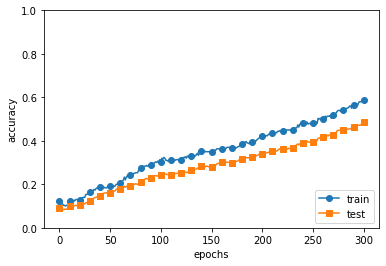

In [17]:
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True)

x_train = x_train[:300]
t_train = t_train[:300]

use_dropout = True
dropout_ratio = 0.2

network = MultiLayerNetExtend(input_size = 784,
                             hidden_size_list = [100, 100, 100, 100, 100, 100],
                             output_size = 10,
                             use_dropout = use_dropout,
                             dropout_ration = dropout_ratio)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                 epochs = 301, mini_batch_size = 100,
                 optimizer = 'sgd', optimizer_param = {'lr':0.01},
                 verbose = True)

trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()